In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import shap

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/pranavdubeyX/Datasets/refs/heads/main/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3)*100)

Accuracy: 72.1


# Basic XAI

In [5]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78        99
           1       0.61      0.62      0.61        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154



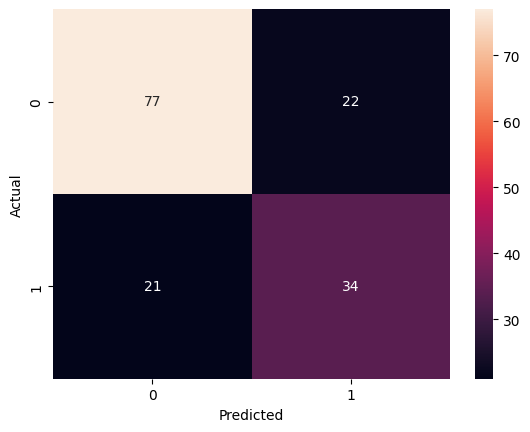

In [8]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [9]:
feature_imp = rf.feature_importances_
indices = np.argsort(feature_imp)[::-1]
print("Feature Importances:\n")

for i in range(X_train.shape[1]):
    print(f"{X.columns[indices[i]]}: {round(feature_imp[indices[i]], 4)}")

Feature Importances:

Glucose: 0.2589
BMI: 0.17
Age: 0.1409
DiabetesPedigreeFunction: 0.1238
BloodPressure: 0.0881
Pregnancies: 0.0766
Insulin: 0.0761
SkinThickness: 0.0656


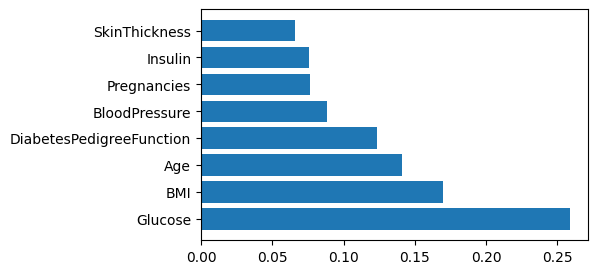

In [10]:
plt.figure(figsize=(5, 3))
plt.barh(range(X_train.shape[1]), feature_imp[indices], align='center')
plt.yticks(range(X_train.shape[1]), [X.columns[i] for i in indices]);

# SHAP (SHapley Additive exPlanations)

#### Why SHAP? How is it different than LIME?


1. LIME focuses on explaining individual predictions by approximating the model locally with an interpretable model (such as linear regression) around the specific instance. It generates explanations for each instance by perturbing the input and observing how the model's output changes.
    - Local explanations: LIME provides a local approximation around a single prediction. </br></br>

    

2. SHAP, on the other hand, provides a global explanation of the model’s behavior, while also offering local explanations for each prediction. SHAP values are grounded in cooperative game theory and ensure consistency, i.e., the more a feature contributes to the prediction, the higher its SHAP value.
    - Global and local explanations: SHAP provides both local and global insights and is model-agnostic, but it ensures that the explanations are consistent across the dataset.
    - Key difference: SHAP has a solid theoretical foundation (based on Shapley values) and guarantees fairness in assigning importance to each feature. LIME approximates the model locally and does not guarantee this level of consistency.

In [13]:
# Create the explainer object
explainer = shap.TreeExplainer(rf)

shap_values = explainer.shap_values(X)
shap_values[0]

array([[-0.0014442 ,  0.0014442 ],
       [-0.15844991,  0.15844991],
       [-0.01740507,  0.01740507],
       [-0.02448706,  0.02448706],
       [-0.03700118,  0.03700118],
       [-0.08479007,  0.08479007],
       [-0.07021485,  0.07021485],
       [-0.16083306,  0.16083306]])

#### What are SHAP values?

SHAP values are a way to explain the output of machine learning models by attributing the contribution of each feature to a particular prediction. These values come from Shapley values in cooperative game theory, which were adapted for machine learning models.

They how much each feature value (input feature) contributes to the **difference between the actual prediction and the model's average prediction**.
    
**Calculation:**
the model is treated as a "game," and each feature is a "player" that contributes to the prediction. The formula calculates the average contribution of each feature by considering all possible combinations of features and how their inclusion affects the model's output.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*A42T3muP4qhsWurPgo4JAw.png">

![image.png](attachment:68bcc8f8-823b-46be-87f8-0000045da8e6.png)



**What SHAP values tell about a feature?**

1. Feature Contribution: SHAP values show how much a feature contributed to moving the prediction away from the baseline (average model prediction). A **positive SHAP** value means the feature pushed the model's output higher, while a **negative SHAP** value means the feature pushed the model's output lower.

2. Magnitude: The magnitude of a SHAP value indicates how strongly a feature affected the model’s output. Larger values (in either direction) indicate that the feature had a greater influence on the prediction.

3. Direction: The direction (positive or negative) tells whether the feature increased or decreased the prediction:

    - Positive SHAP value: The feature helped in predicting a higher value or a certain class (e.g., predicting "diabetes").
    - Negative SHAP value: The feature helped in predicting a lower value or a different class (e.g., predicting "no diabetes").

4. Feature Interactions: SHAP values also provide insights into how features interact with each other. For example, if a feature has a strong effect when another feature is high but not when it is low, SHAP values can highlight this interaction.

**Our case:**

We have a simple model predicting diabetes (Outcome 1 or 0), and we want to understand the role of the Glucose feature:

- If Glucose has a positive SHAP value, it means higher glucose levels are likely contributing to a higher probability of predicting a positive outcome (diabetes).
- If Glucose has a negative SHAP value, it suggests that higher glucose levels are likely contributing to a lower probability of predicting diabetes, or the feature might be working against the prediction.

**Overall conclusion:**

1. SHAP values quantify the contribution of each feature to a prediction.
2. They are calculated using a combination of game theory (Shapley values) and model behavior.
3. Positive SHAP values mean the feature increased the prediction, and negative values mean the feature decreased it.
4. The magnitude of SHAP values tells you how significant the feature is for that prediction.

**Before interpreting the chart below:**

1. SHAP values are not in the same unit as the original features because they represent how much each feature contributes to the prediction relative to a baseline value, which is typically the mean prediction across the entire dataset. This is because:
   - SHAP values are based on the prediction difference between the baseline and the actual model prediction, not the raw feature values.
   - The model might use internal transformations (like activation functions, scaling, or normalization) which change how the features influence the prediction compared to their raw values.
2. The SMAP unit differs in Regresison and Classification:
   - Since regression model predicts a continuous output, SHAP values are expressed in the same units as the target variable.
   - In calssification, model predicts class based on the poutput of probability ( 0 to 1), the SHAP values represents the contributions to the probability of a class.

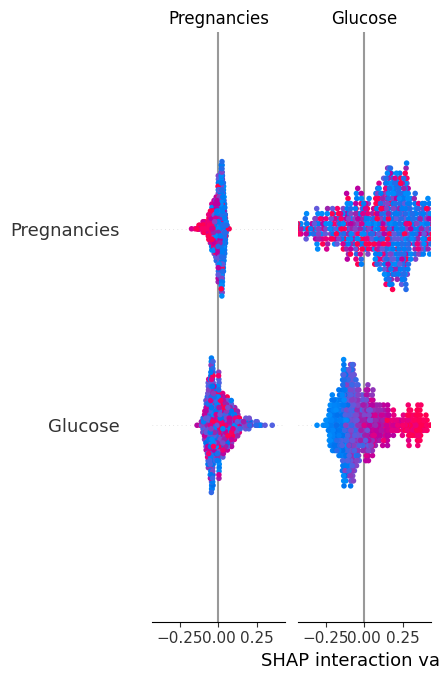

In [14]:
# Visualize the SHAP values
shap.initjs()
shap.summary_plot(shap_values, X)
# shows only the most important features

**Interpretation:

1. x-axis: The SHAP values, which represent the impact of a feature on the model's output. A higher SHAP value means the feature had a more significant effect on the prediction. The x-axis shows how far each feature's value shifted the model's output.
    - Positive SHAP values: The feature pushed the model's prediction higher.
    - Negative SHAP values: The feature pushed the model's prediction lower.

2. y-axis: Features sorted by importance. The most important feature appears at the top. For the above plot, Pregnancies and Glucose are the top two most important features.
    - Features higher on the y-axis had more influence on the model's predictions.

3. Colors: The color of the dots represents the feature’s value. The blue points correspond to lower feature values, and the red points correspond to higher feature values. For example:
    - If a feature has higher SHAP values when its value is high (as shown in red), it indicates that higher values of this feature push the prediction towards one class (e.g., "diabetes" in this case).
    - If the feature has higher SHAP values when its value is low (blue), it means the opposite.

4. Distribution: Each dot represents an individual data point. The spread of the dots shows the variation in how much the feature impacts the prediction across the dataset. This plot shows **all datapoints/rows**.

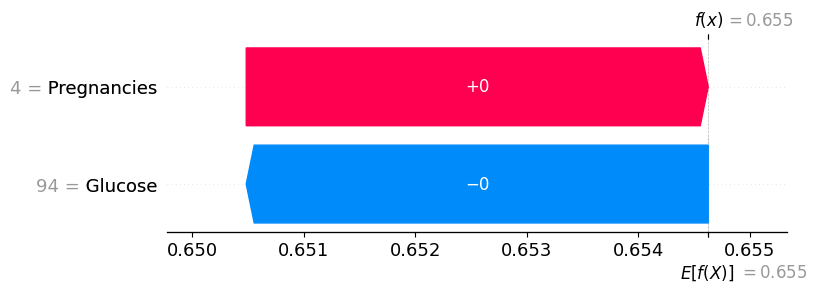

In [35]:
# For a specific instance, say X_test.iloc[1]
instance = X_test.iloc[50]

# Calculate SHAP values for this instance
shap_values_for_instance = explainer.shap_values(instance)

# Create the explanation object for this instance
explanation = shap.Explanation(values = shap_values_for_instance[0],
                                base_values = explainer.expected_value[0],
                                data = instance.values,
                                feature_names = X_test.columns)

# Plot the waterfall chart
shap.plots.waterfall(explanation)



In [23]:
explainer.expected_value[0]

0.6546254071661239

**Interpreting the above chart with instance value 1:**

1. Baseline (E[f(X)]): The value shown in the plot as E[f(X)] = 0.655 is the expected value of the model’s output. This is the average prediction made by the model across all data points, and it’s used as the starting point for calculating SHAP values.
2. Final Prediction (f(x)): This is the prediction for a specific instance, which in this case is also 0.655, indicating no significant deviation from the baseline.
3. Pregnancies (SHAP value = +0.03): The Pregnancies feature increases the model's prediction by +0.03. This means that the presence of Pregnancies (with its specific value) is pushing the model's prediction slightly higher.
4. Glucose (SHAP value = -0.03): The Glucose feature decreases the model's prediction by -0.03. In this case, the value for Glucose is pulling the model's prediction down.
5.

The model's prediction for this observation is largely influenced by Pregnancies and Glucose, but the contributions are nearly equal and opposite, so they balance each other out in the final result.

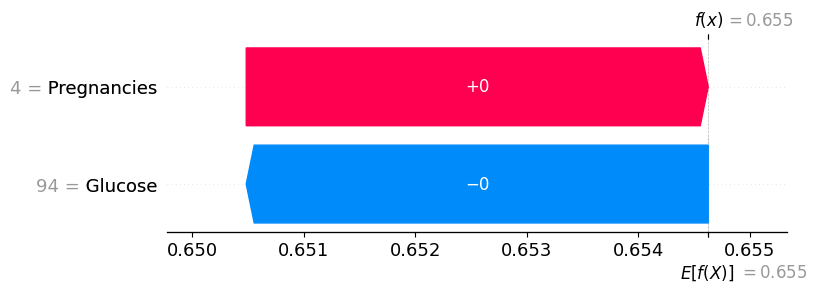

In [24]:
# instance to explore
instance = X_test.iloc[50]

# SHAP values for this instance
shap_values_for_instance = explainer.shap_values(instance)

# explantion
explanation = shap.Explanation(values=shap_values_for_instance[0],
                                 base_values=explainer.expected_value[0],
                                 data=instance.values,
                                 feature_names=X_test.columns)

#Plotting
shap.plots.waterfall(explanation)

Noticed any issue?

In [28]:
# force plot
shap.initjs()

shap.plots.force(explainer.expected_value[0], shap_values_for_instance[0])

In [30]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values_for_instance[1])

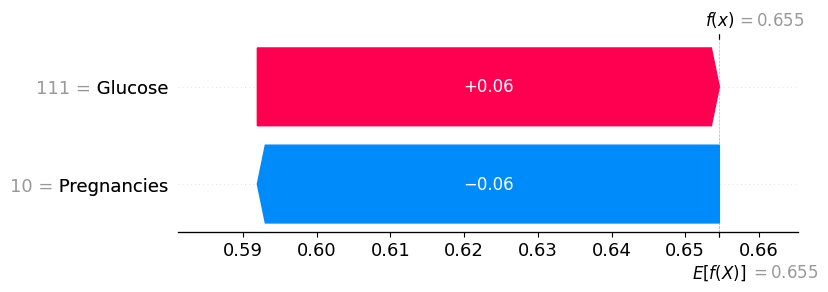

In [32]:
# to recalculate the SHAP values

instance = X_test.iloc[10]

# Recalculate SHAP values for this specific instance
shap_values_for_instance = explainer.shap_values(instance)

# Create the explanation object using SHAP values for this instance
explanation = shap.Explanation(values=shap_values_for_instance[0],
                                base_values=explainer.expected_value[0],
                                data=instance.values,
                                feature_names=X_test.columns)

# Plot the waterfall for this instance
shap.plots.waterfall(explanation)

# Plot the force plot for this instance (for class 0 in binary classification)
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values_for_instance[0])  # Class 0


In [34]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values_for_instance[1])

**Waterfall Plot:**
1. Baseline Prediction (Expected Value): The model starts with an expected prediction of 0.65 (as indicated by E[f(X)] = 0.65). This is the average prediction the model makes across all instances.

2. Feature Contributions:
- Glucose (Feature 0): This feature increases the prediction by +0.06. The red color indicates a positive contribution, meaning that higher glucose levels are pushing the prediction towards a higher probability of the target class.
- Pregnancies (Feature 1): This feature decreases the prediction by -0.06. The blue color indicates a negative contribution, meaning that higher pregnancy counts are pushing the prediction towards a lower probability of the target class.
3. Final Prediction: After considering both features, the final prediction is 0.655, which is the result of the combined effects of Glucose and Pregnancies. Since the contributions of both features cancel each other out (one positive, one negative), the final prediction is very close to the baseline of 0.65.

**Force Plot:**
1. Baseline (Expected Value): The baseline value in the force plot is also 0.65, which is where the prediction starts.

2. Feature Contributions:
- Glucose (Feature 0): The red bar indicates that Glucose has a positive effect on the prediction. It pushes the final prediction to the right, which means it increases the likelihood of the positive class.
- Pregnancies (Feature 1): The blue bar indicates that Pregnancies has a negative effect on the prediction. It pulls the final prediction to the left, reducing the likelihood of the positive class.
